In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
from re import findall as fa
import sqlite3
import pymorphy2
import math


from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier 
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from scipy.stats.stats import pearsonr as corr

from nltk.tokenize import word_tokenize

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

from keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.models import Model, Sequential

import seaborn as sns

import matplotlib.pyplot as plt
from jupyterthemes import jtplot #внешний вид ноутбука и графиков
jtplot.style(theme='onedork')

import random
random.seed(1228)

from sklearn.metrics import precision_score, recall_score, confusion_matrix

%matplotlib inline

Using TensorFlow backend.


In [2]:
text = """
Иногда я пишу о книгах, лубочек которые произвели на меня впечатление. Писать большие отзывы сейчас не хочется, поэтому в порядке перечисления.
"Атлант расправил плечи" - за последнее время понравилась больше всего наряду с Довлатовым (но насчет последнего сомнений и не было). Почему-то раньше я думал, что это что-то вроде "Финансиста" Драйзера. Так же, видимо, думают и люди, рисующие мемы "сын маминой подруги расправил плечи". А на самом деле книга об альтернативной вселенной, где в США наступил социализм. Очень рекомендую.
Что до "Финансиста" Драйзера, то т.д. он надолго отбил у меня желание читать этого автора. Не потому что мне не интересно читать про рынок - наоборот, про рынок интересно. Но всё остальное там скучно, особенно герои. Может быть, так и было задумано, но я это не люблю.
Дилогия об Остапе Бендере - сыночек начинаются обе книги весело, кончаются обе книги уныло. Не столько с точки зрения событий, сколько с точки зрения того, как трансформируется язык. Поэтому от них остается неприятное ощущение, хотя написаны они ярко, весело и интересно. Впрочем, не пойти на такую сделку вряд ли можно было в условиях, в которых работали авторы.
"Три мушкетера". Ну, не побоюсь если сыночком доченька сыночка оболочка опочка б я хотел бы этого я слова, такое. Занятно, но не более того - я сейчас даже с трудом вспомнил об этой книжке. Главный интерес книжка представляет с исторической точки зрения. В том числе и потому, что является убедительным доказательством, что во Франции в 17м веке был интернет и портативные телепорты - ну или по крайней мере бесстыдная сценарная магия.
Отто Кариус, "Тигры в грязи". орешек печьками котик солдатиков маленькую котеночек котенька необходимость тк изза тогочто обязана Язык Все всяк по видимому каждому каждый каждая этой можетбыть кажеться наверное наверно книги совершенно ужасен, может быть, потому что её писал солдат. Но прочитать очень стоит, потому что мало что может быть так ценно, как новая точка зрения на нечто хорошо знакомое!
"""

In [3]:
fa('\sбы?\s',text)

[' б ', ' бы ']

In [4]:
def ct(x, co=0, steep=0, ec50=0.5, level='max', adb=True):
    def carryover(x, l=0):
        co = []
        co.append((1-l)*x[0])
        for i in range(1,len(x)):
            co.append((1-l)*x[i] + l*co[i-1])
        return co

    def adbudg(x, steep, ec50, level):
        cap = max(x) if level == 'max' else level
        adb = []
        for i in x:
            adb.append(0 if i == 0 else cap/(1 + (i/(cap*ec50))**(-steep))) 
        return adb

    def logcurve(x, steep, ec50, level):
        cap = max(x) if level == 'max' else level*max(x)
        crv = []
        for i in x:
            crv.append(cap/(1+math.exp((-steep)*(i/cap-ec50))) - cap/(1+math.exp(steep*ec50)))
        return crv
      
    ct = x
    if steep > 0:
        ct = adbudg(x, steep, ec50, level) if adb else logcurve(x, steep, ec50, level)
    ct = carryover(ct, co) if co > 0 else ct
    return ct

def cleanse(s):
    rgxp = '[\`\)\(\|©~^<>/\'\"\«№#$&\*.,;=+?!\—_@:\]\[%\{\}\\n]'
    return re.sub(' +', ' ', re.sub(rgxp, ' ', s.lower()))

def set_groups(x, dev=1, M=50, SD=10):
    if x > M+dev*SD:
        return 'high'
    elif x < M-dev*SD:
        return 'low'
    else:
        return 'average'
    
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
imper = ['долж(?:ен|на|ны|но)', 'обязан(?:а|ы|о|)', 
         'надо\W', 'нуж(?:но|ен|на|ны)', 
         'требуеть?ся', 'необходим(?:а|ы|о|)\W']
racio = ['по\s?этому', 'по\s?тому,?\s?что', 'следовательно', 
         'из[\s-]?за\s?того,?\s?что', 'из[\s-]?за\s?этого', 
         'по\s?причине', 'в\s?следстви[ие]', 'так\s?как', 'т\.?к\.?']
dimin = ['\w+[ое]ньк(?:ая|ий|ое|ие|ую|ого|ому|ой|ими|а|о|у|е)', 
         '\w+очек\s', '\w+[ие]к(?:ами?|ов|у|а|е|и|)\s']
extrem = ['че?резвычайно','слишком','чере[cз]чур','ужасно','безумно','крайне',
         'исключительно','предельно','исключительно','невероятно','в высшей степени']
fa('|'.join(extrem), text)

['крайне']

In [6]:
allpos= ['PRED', 'None', 'PRTS', 'ADJF', 'INFN', 
         'PRTF', 'NOUN', 'ADVB', 'VERB', 'NPRO', 
         'NUMR', 'CONJ', 'ADJS', 'PRCL', 'PREP', 'COMP', 'INTJ']

In [7]:
def extract_features(text, 
                     morph=pymorphy2.MorphAnalyzer(), 
                     pos_types=['ADJF', 'NOUN', 'ADVB', 'VERB', 'CONJ', 'PREP', 'INTJ', 'None'],
                     uncert = ['наверное?', 'может[\s-]?быть', 'кажеть?ся', 
                               'видимо', 'возможно', 'по[\s-]?видимому', 
                               'вероятно', 'должно[\s-]?быть','пожалуй', 'как[\s-]?видно'],
                     cert = ['очевидно','конечно','точно','совершенно',
                             'не\s?сомненно','разумееть?ся', 
                             'по[\s-]?любому','сто[\s-]?пудово?'],
                     quan = ['вс[её]x?','всегда','ни-?когда', 'постоянно', 
                             'ник(?:то|ого|ому|ем)', 
                             'кажд(?:ый|ая|ой|ому?|ое|ого|ую|ые|ою|ыми?|ых)',
                             'всяк(?:ий|ая|ое|ого|ую|ому?|ой|ою|ими?|их|ие)',
                             'люб(?:ой|ая|ое|ого|ому?|ую|ой|ыми?|ых|ые)'],
                     imper = ['долж(?:ен|на|ны|но)', 'обязан(?:а|ы|о|)', 
                              'надо\W', 'нуж(?:но|ен|на|ны)', 
                              'требуеть?ся', 'необходим(?:а|ы|о|)\W'],
                     racio = ['по\s?этому', 'по\s?тому,?\s?что', 'следовательно', 
                              'из[\s-]?за\s?того,?\s?что', 'из[\s-]?за\s?этого', 
                              'по\s?причине', 'в\s?следстви[ие]', 'так\s?как', 'т\.?к\.?',
                              'поскольк[оу]', 'чтобы'],
                     dimin = ['\w+[ое]ньк(?:ая|ий|ое|ие|ую|ого|ому|ой|ими|а|о|у|е)', 
                              '\w+очек\s', '\w+[ие]к(?:ами?|ов|у|а|е|и|)\s'],
                     extrem = ['че?резвычайно', 'слишком', 'чере[cз]чур', 'ужасно',
                               'безумно', 'крайне', 'исключительно', 'предельно',
                               'исключительно', 'невероятно', 'в высшей степени']
                    ):
    
    from re import findall as fa
    #length in chars and words
    len_char = len(text)
    len_word = len(text.split())
    len_sent = len(fa('[^\.\!\?]+[\.\!\?]', text))
    len_sent = len_sent if len_sent else 1
    pun = fa('[\.+,!\?:-]',text)
    n_pun = len(pun)
    braсket_list = fa('[\(\)]',text)
      
    #POS & grammem
    def cleanse(s):
        rgxp = '[\`\)\(\|©~^<>/\'\"\«№#$&\*.,;=+?!\—_@:\]\[%\{\}\\n]'
        return re.sub(' +', ' ', re.sub(rgxp, ' ', s.lower()))
    
    def parse_text(text, morph=morph):
        tokens = cleanse(text).split()
        return [morph.parse(t) for t in tokens]
    
    parsed_text = parse_text(text)
    pos_list = [str(p[0].tag.POS) for p in parsed_text]
    n_nouns = len([t for t in pos_list if t=='NOUN'])
    n_verbs = len([t for t in pos_list if t=='VERB'])
    n_ad = len([t for t in pos_list if t in ['ADJF','ADVB']])
    anim_list = [str(p[0].tag.animacy) for p in parsed_text]
    pers_list = [str(p[0].tag.person) for p in parsed_text]
    tns_list = [str(p[0].tag.tense) for p in parsed_text]
    asp_list = [str(p[0].tag.aspect) for p in parsed_text]
      
    r = lambda x: round(x, 4)
    d = lambda x, y: x / y if y else 0.0
    
    features = {
        #surface features
        'len_char': len_char, 
        'len_word': len_word,
        'len_sent': len_sent,
        'm_len_word': r(len_char / len_word),
        'm_len_sent': r(len_word / len_sent),
        #punctuation
        'p_pun': r(len(pun) / len_char),
        'p_dot': r(d(len([i for i in pun if i=='.']), len(pun))),
        'p_qm': r(d(len([i for i in pun if i=='?']), len(pun))),
        'p_excl': r(d(len([i for i in pun if i=='!']), len(pun))),
        'p_comma': r(d(len([i for i in pun if i==',']), len(pun))),
        'p_brkt': r(len(braсket_list) / len_char),
        'p_brkt_up': r(d(len([i for i in braсket_list if i==')']), len(braсket_list))),
        #POS form
        'pos_form': ' '.join(pos_list),
        'pos_richness': len(set(pos_list)),
        #grammem features
        'p_anim': r(d(len([t for t in anim_list if t=='anim']), n_nouns)),
        'p_1per': r(d(len([t for t in pers_list if t=='1per']), n_verbs)),
        'p_3per': r(d(len([t for t in pers_list if t=='3per']), n_verbs)),
        'p_past': r(d(len([t for t in tns_list if t=='past']), n_verbs)),
        'p_fut': r(d(len([t for t in tns_list if t=='futr']), n_verbs)),
        'p_pres': r(d(len([t for t in tns_list if t=='pres']), n_verbs)),
        'p_perf': r(d(len([t for t in asp_list if t=='perf']), n_verbs)),
        'p_conj': r(d(len(fa('\sбы?\s',text)), n_verbs)),
        #lexical features
        'p_uncert': r(len(fa('|'.join(uncert), text.lower())) / len_word),
        'p_cert': r(len(fa('|'.join(cert), text.lower())) / len_word),
        'p_quan': r(len(fa('|'.join(quan), text.lower())) / len_word),
        'p_imper': r(len(fa('|'.join(imper), text.lower())) / len_word),
        'p_racio': r(len(fa('|'.join(racio), text.lower())) / len_word),
        'p_dimin': r(len(fa('|'.join(dimin), text.lower())) / len_word),    
        'p_extrem': r(len(fa('|'.join(extrem), text.lower())) / len_word),    
    }
    
    for f in pos_types:
        features['p_'+f] = r(len([t for t in pos_list if t==f])/len(pos_list))
        
    return features

In [8]:
%%time
extract_features(text)

Wall time: 78.1 ms


{'len_char': 2002,
 'len_sent': 25,
 'len_word': 314,
 'm_len_sent': 12.56,
 'm_len_word': 6.3758,
 'p_1per': 0.4194,
 'p_3per': 0.4194,
 'p_ADJF': 0.1048,
 'p_ADVB': 0.127,
 'p_CONJ': 0.0984,
 'p_INTJ': 0.0,
 'p_NOUN': 0.273,
 'p_None': 0.0222,
 'p_PREP': 0.0952,
 'p_VERB': 0.0984,
 'p_anim': 0.3023,
 'p_brkt': 0.001,
 'p_brkt_up': 0.5,
 'p_cert': 0.0032,
 'p_comma': 0.4754,
 'p_conj': 0.0645,
 'p_dimin': 0.0318,
 'p_dot': 0.3934,
 'p_excl': 0.0164,
 'p_extrem': 0.0032,
 'p_fut': 0.0645,
 'p_imper': 0.0032,
 'p_past': 0.5806,
 'p_perf': 0.4839,
 'p_pres': 0.5161,
 'p_pun': 0.0305,
 'p_qm': 0.0,
 'p_quan': 0.0223,
 'p_racio': 0.0255,
 'p_uncert': 0.0287,
 'pos_form': 'ADVB NPRO VERB PREP NOUN NOUN ADJF VERB PREP NPRO NOUN INFN ADJF NOUN ADVB PRCL VERB ADVB PREP NOUN NOUN NOUN VERB NOUN None PREP ADJF NOUN VERB COMP ADVB ADVB PREP NOUN CONJ PREP ADJF NOUN CONJ PRCL VERB ADVB COMP NPRO VERB CONJ PRCL NPRO PRCL NOUN NOUN CONJ PRCL ADVB VERB CONJ NOUN PRTF NOUN NOUN ADJF NOUN VERB NOUN CON

In [9]:
len(extract_features(text))

37

In [10]:
#get text data from db
conn = sqlite3.connect('ud.db')
c = conn.cursor()
query = 'SELECT DISTINCT owner_id, text FROM posts WHERE text IS NOT NULL AND text != "";'
texts = pd.read_sql(query, conn)
lens = np.array([len(str(t)) for t in texts.text])
trsh_up, trsh_lo = 7000, 900
lens = np.array([len(str(t)) for t in texts.text])
texts = texts[(lens < trsh_up) & (lens > trsh_lo)]
texts.shape

(1648, 2)

In [11]:
m = pymorphy2.MorphAnalyzer()
tqdm.pandas(desc="Calculate features")
df_feat = pd.DataFrame.from_records(list(texts.text.progress_apply(extract_features, morph=m)))
df_feat.index = texts.index
texts_feat = pd.concat([texts, df_feat], axis=1, join='inner')
feat_names = list(extract_features('ы').keys())
feat_names.remove('pos_form')
texts_feat.shape

Calculate features: 100%|█████████████████████████████████| 1648/1648 [00:27<00:00, 59.75it/s]


(1648, 39)

In [12]:
#load psychological data and transform traits
names_HEX = ['HEX1_eX', 'HEX2_A', 'HEX3_C', 'HEX4_E', 'HEX5_O', 'HEX6_H']
names_TWf = ['TWf1_eX', 'TWf2_A', 'TWf3_C', 'TWf4_E', 'TWf5_O', 'TWf6_H']
names_TWc = ['TWc1_eX', 'TWc2_A', 'TWc3_C', 'TWc4_N', 'TWc5_O', 'TWc6_H']
names_M = ['M'+i[3:] for i in names_HEX]
cols = ['id', 'sex'] + names_HEX + names_TWf + names_TWc

traits = pd.read_csv('data/survey_data.csv', sep=';', decimal=',', usecols=cols)

for i, t in enumerate(names_M):
    traits[t] = (traits[names_HEX[i]] + traits[names_TWf[i]] + traits[names_TWc[i]])/3

trait_names = names_HEX + names_TWf + names_TWc + names_M

print('trait high average low')
for trait in trait_names:
    scale = trait + '_nom'
    traits[scale] = traits[trait].apply(set_groups, dev=0.5)
    print(trait, [traits[scale].value_counts()[i] for i in range(3)])
    
trait_names = names_M

trait high average low
HEX1_eX [53, 51, 48]
HEX2_A [58, 51, 43]
HEX3_C [53, 52, 47]
HEX4_E [57, 48, 47]
HEX5_O [56, 50, 46]
HEX6_H [54, 50, 48]
TWf1_eX [57, 50, 45]
TWf2_A [55, 51, 46]
TWf3_C [62, 47, 43]
TWf4_E [53, 50, 49]
TWf5_O [57, 49, 46]
TWf6_H [53, 51, 48]
TWc1_eX [59, 49, 44]
TWc2_A [53, 52, 47]
TWc3_C [54, 52, 46]
TWc4_N [58, 49, 45]
TWc5_O [74, 40, 38]
TWc6_H [68, 44, 40]
M1_eX [61, 46, 45]
M2_A [59, 50, 43]
M3_C [64, 47, 41]
M4_E [69, 43, 40]
M5_O [65, 45, 42]
M6_H [66, 45, 41]


In [13]:
#join data
data = pd.merge(texts_feat, traits, how='left', left_on='owner_id', right_on='id')
data.text = data.text.apply(cleanse)
data.shape

(1687, 89)

In [14]:
#apply curve transformation
for f in feat_names:
    data[f] = ct(data[f], steep=1.5, ec50=0.5, level='max', adb=False)

In [15]:
train, test = train_test_split(data, test_size=0.12, random_state=42)
print('Train sample: {}\nTest sample: {}'.format(len(train), len(test)))

Train sample: 1484
Test sample: 203


In [16]:
#prepare X
X_train = train.loc[:,feat_names]
X_test = test.loc[:,feat_names]

#words tf:idf
vect_words = TfidfVectorizer(ngram_range=(1, 3), 
                     analyzer='word', 
                     tokenizer=word_tokenize, 
                     min_df = 30, 
                     max_df = 0.7, 
                     max_features = 10000)

train_w_vec = vect_words.fit_transform(train.loc[:,'text'])
test_w_vec = vect_words.transform(test.loc[:,'text'])

print('WORDS')
print('\nIncluded tokens ({})'.format(train_w_vec.shape[1]))
print(np.array(vect_words.get_feature_names())\
      [np.random.randint(0, len(vect_words.get_feature_names()), 20)])
print('\nExcluded tokens ({})'.format(len(vect_words.stop_words_)))
print(np.array(list(vect_words.stop_words_))\
      [np.random.randint(0, len(vect_words.stop_words_), 20)])

#pos tf:idf
vect_pos = TfidfVectorizer(ngram_range=(2, 4), 
                     analyzer='word',  
                     min_df = 50, 
                     max_df = 0.5, 
                     max_features = 5000)
train_p_vec = vect_pos.fit_transform(train.loc[:,'pos_form'])
test_p_vec = vect_pos.transform(test.loc[:,'pos_form'])

print('\nPOS')
print('\nIncluded tokens ({})'.format(train_p_vec.shape[1]))
print(np.array(vect_pos.get_feature_names())\
      [np.random.randint(0, len(vect_pos.get_feature_names()), 20)])
print('\nExcluded tokens ({})'.format(len(vect_pos.stop_words_)))
print(np.array(list(vect_pos.stop_words_))\
      [np.random.randint(0, len(vect_pos.stop_words_), 20)])

X_train = np.hstack((train_w_vec.todense(), train_p_vec.todense(), train.loc[:,feat_names]))
X_test = np.hstack((test_w_vec.todense(), test_p_vec.todense(), test.loc[:,feat_names]))
print(X_train.shape, X_test.shape)

WORDS

Included tokens (1707)
['это не' 'да и' 'бояться' 'те' 'никогда' 'меньше' 'второе' 'кроме'
 'что было' 'особенно' 'я не знаю' 'детей' 'знаю' 'но это' 'моего' 'нем'
 'всей' 'больше всего' 'знаете' 'готова']

Excluded tokens (728887)
['так звуку' 'мешает присутствие' 'секции' 'статьи на досуге'
 'стоят кое-где' 'стулом на стуле' 'surely not' 'не сходиться'
 'работает официантки все' 'тридцать конечно лень' '» организатор'
 'двести тринадцать' 'за днями' 'мерещились шебуршания' 'за чужое пару'
 'of the soviets' 'обаятельная заурядная хохотушка' 'поморщилась и'
 'гореть будет' 'ты погибнешь']

POS

Included tokens (2625)
['adjf conj prep adjf' 'comp adjf noun' 'conj prcl advb advb'
 'conj conj prep noun' 'infn conj infn noun' 'pred prcl infn'
 'prep noun conj infn' 'prcl infn npro' 'prcl verb prep' 'npro conj conj'
 'advb prep noun verb' 'verb conj noun conj' 'advb adjf verb'
 'prep npro advb' 'prcl npro prcl verb' 'noun grnd noun'
 'noun adjf conj advb' 'adjf noun prcl advb' 'npro 

In [17]:
#correlations
for trait in trait_names:
    print('\n{}\n{}\n{}\n'.format('='*40,trait,'='*40))
    for feat in feat_names:
        cor = corr(data.loc[:,trait],data.loc[:,feat])
        if abs(cor[0]) > 0.1:
            print('{} | {} : r = {:.2}'.format(feat, trait, cor[0], cor[1]))


M1_eX

m_len_sent | M1_eX : r = -0.11
p_brkt_up | M1_eX : r = -0.16
p_anim | M1_eX : r = 0.13
p_quan | M1_eX : r = 0.12
p_VERB | M1_eX : r = 0.14
p_None | M1_eX : r = -0.13

M2_A

len_sent | M2_A : r = 0.1
m_len_sent | M2_A : r = -0.2
pos_richness | M2_A : r = 0.19
p_3per | M2_A : r = 0.13
p_past | M2_A : r = -0.12
p_fut | M2_A : r = 0.19
p_pres | M2_A : r = 0.14
p_perf | M2_A : r = 0.14
p_ADJF | M2_A : r = 0.14
p_NOUN | M2_A : r = 0.21
p_ADVB | M2_A : r = -0.14
p_VERB | M2_A : r = 0.17
p_None | M2_A : r = -0.23

M3_C

p_anim | M3_C : r = -0.14
p_past | M3_C : r = -0.21
p_fut | M3_C : r = 0.12
p_pres | M3_C : r = 0.16
p_ADVB | M3_C : r = -0.13

M4_E

p_brkt | M4_E : r = 0.13
p_brkt_up | M4_E : r = 0.24
p_anim | M4_E : r = -0.15
p_1per | M4_E : r = 0.21
p_3per | M4_E : r = -0.22
p_NOUN | M4_E : r = -0.15
p_ADVB | M4_E : r = 0.14

M5_O

len_sent | M5_O : r = -0.11
m_len_sent | M5_O : r = -0.12
p_1per | M5_O : r = 0.1
p_3per | M5_O : r = 0.14
p_pres | M5_O : r = 0.11
p_quan | M5_O : r = 

In [18]:
def build_model_nom(X_train, X_test, y_train, y_test, vectorizer, model):
    print('{}\nBUILDING MODEL FOR {}\n{}\n'.format("="*40,y_train.name,"="*40))
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    print('Accuracy on training sample: {:.2%}'.format(accuracy_score(y_train, y_train_pred)))
#     print(classification_report(y_train, y_train_pred))
    y_test_pred = model.predict(X_test)
    print('Accuracy on test sample: {:.2%}'.format(accuracy_score(y_test, y_test_pred)))
#     print(classification_report(y_test, y_test_pred))
    labels = y_train.unique()
    sns.set_context("notebook")
    plt.figure(figsize=(4,3))
    sns.heatmap(data=confusion_matrix(y_test, y_test_pred, labels = labels), 
                annot=True, fmt="d", cbar=False, 
                xticklabels=labels, yticklabels=labels, cmap='viridis')
    plt.title("Confusion matrix")
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title("Confusion matrix for "+y_train.name, fontsize=12, fontweight='bold');
    plt.show()

In [19]:
def build_model_cont(X_train, X_test, y_train, y_test, vectorizer, model):
    print('{}\nBUILDING MODEL FOR {}\n{}\n'.format("="*40,y_train.name,"="*40))
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    print('MAPE on training sample: {:.2f}%'.format(mape(y_train, y_train_pred)))
    print('R2 on training sample: {:.3f}'.format(r2_score(y_train, y_train_pred)))
    y_test_pred = model.predict(X_test)
    print('\nMAPE on test sample: {:.2f}%'.format(mape(y_test, y_test_pred)))
    print('R2 on training sample: {:.3f}'.format(r2_score(y_test, y_test_pred)))
#     print('\nHigh pole')
#     [print(a) for a in sorted(list(zip(model.coef_, feat_names)), reverse=True)[0:5]]
#     print('\nLow pole')
#     [print(a) for a in sorted(list(zip(model.coef_, feat_names)))[0:5]]
    print()

BUILDING MODEL FOR M1_eX_nom

Accuracy on training sample: 88.88%
Accuracy on test sample: 64.53%


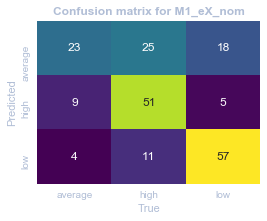

BUILDING MODEL FOR M2_A_nom

Accuracy on training sample: 90.57%
Accuracy on test sample: 69.95%


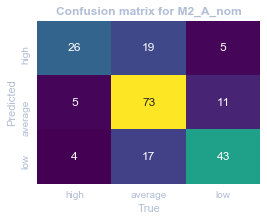

BUILDING MODEL FOR M3_C_nom

Accuracy on training sample: 88.68%
Accuracy on test sample: 64.04%


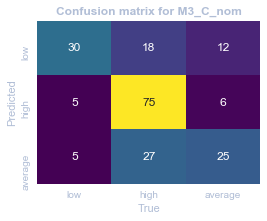

BUILDING MODEL FOR M4_E_nom

Accuracy on training sample: 87.74%
Accuracy on test sample: 71.43%


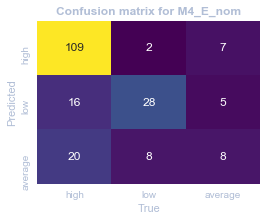

BUILDING MODEL FOR M5_O_nom

Accuracy on training sample: 85.51%
Accuracy on test sample: 67.98%


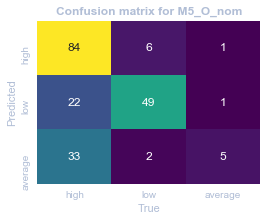

BUILDING MODEL FOR M6_H_nom

Accuracy on training sample: 83.36%
Accuracy on test sample: 67.00%


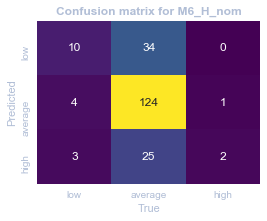

In [20]:
for trait in trait_names:
    trait = trait+'_nom'
    lm = RandomForestClassifier(n_estimators=200, max_features='log2', 
                                min_samples_leaf=8, oob_score = True)  
    lm = LogisticRegression()
#     lm = MultinomialNB()
#     lm = GradientBoostingClassifier()
    build_model_nom(X_train=X_train, X_test=X_test, 
                y_train = train.loc[:,trait], y_test = test.loc[:,trait],
                vectorizer=None, model=lm)

In [21]:
for trait in trait_names:
    lm = RandomForestRegressor(n_estimators=100, max_features='log2', 
                                min_samples_leaf=5, oob_score = True)  
#     lm = LinearRegression()
#     lm = GradientBoostingRegressor()
    build_model_cont(X_train=X_train, X_test=X_test, 
                y_train = train.loc[:,trait], y_test = test.loc[:,trait],
                vectorizer=None, model=lm)

BUILDING MODEL FOR M1_eX

MAPE on training sample: 14.26%
R2 on training sample: 0.523

MAPE on test sample: 17.18%
R2 on training sample: 0.232

BUILDING MODEL FOR M2_A

MAPE on training sample: 13.96%
R2 on training sample: 0.547

MAPE on test sample: 18.02%
R2 on training sample: 0.269

BUILDING MODEL FOR M3_C

MAPE on training sample: 13.81%
R2 on training sample: 0.526

MAPE on test sample: 18.38%
R2 on training sample: 0.229

BUILDING MODEL FOR M4_E

MAPE on training sample: 12.13%
R2 on training sample: 0.543

MAPE on test sample: 15.86%
R2 on training sample: 0.227

BUILDING MODEL FOR M5_O

MAPE on training sample: 14.44%
R2 on training sample: 0.503

MAPE on test sample: 18.17%
R2 on training sample: 0.149

BUILDING MODEL FOR M6_H

MAPE on training sample: 7.58%
R2 on training sample: 0.463

MAPE on test sample: 10.10%
R2 on training sample: 0.105



## NN Models

In [22]:
n_features = X_train.shape[1]
batch_size = 512

nb_filter = 250
filter_length = 3
nb_epoch = 10

In [23]:
y_tr = train.loc[:,'M1_eX_nom']
y_te = test.loc[:,'M1_eX_nom']
labels = y_tr.unique()

le = LabelEncoder()
le.fit(labels)
y_train = np_utils.to_categorical(le.transform(y_tr), 3)
y_test = np_utils.to_categorical(le.transform(y_te), 3)
y_true = le.transform(y_te)
print(y_train)

[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 ..., 
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]]


In [24]:
model = Sequential()
model.add(Dense(128, input_shape=(n_features,), activation = 'tanh'))
model.add(Dropout(0.3))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size,  
          validation_split=0.05, verbose=2)

Train on 1409 samples, validate on 75 samples
Epoch 1/10
0s - loss: 2.0041 - acc: 0.3300 - val_loss: 1.2383 - val_acc: 0.4267
Epoch 2/10
0s - loss: 1.4372 - acc: 0.3499 - val_loss: 1.1416 - val_acc: 0.3467
Epoch 3/10
0s - loss: 1.3442 - acc: 0.3392 - val_loss: 1.2058 - val_acc: 0.2800
Epoch 4/10
0s - loss: 1.3752 - acc: 0.3258 - val_loss: 1.1514 - val_acc: 0.2800
Epoch 5/10
0s - loss: 1.3146 - acc: 0.3435 - val_loss: 1.1183 - val_acc: 0.2800
Epoch 6/10
0s - loss: 1.3035 - acc: 0.3378 - val_loss: 1.0985 - val_acc: 0.4267
Epoch 7/10
0s - loss: 1.2934 - acc: 0.3584 - val_loss: 1.0770 - val_acc: 0.4400
Epoch 8/10
0s - loss: 1.2711 - acc: 0.3556 - val_loss: 1.0723 - val_acc: 0.4400
Epoch 9/10
0s - loss: 1.2612 - acc: 0.3534 - val_loss: 1.0738 - val_acc: 0.4400
Epoch 10/10
0s - loss: 1.2826 - acc: 0.3549 - val_loss: 1.0707 - val_acc: 0.4400


In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               559232    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 559,619
Trainable params: 559,619
Non-trainable params: 0
_________________________________________________________________


In [26]:
y_pred = model.predict_classes(X_test)
print(classification_report(y_true, y_pred))

 32/203 [===>..........................] - ETA: 0s

c:\users\mytas\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00        66
          1       0.33      1.00      0.50        65
          2       0.75      0.08      0.15        72

avg / total       0.37      0.35      0.21       203



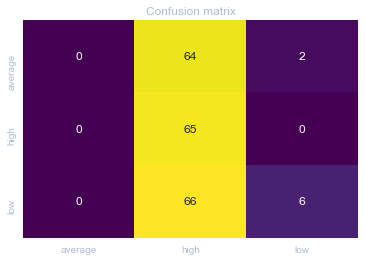

In [27]:
y_true_ = le.inverse_transform(y_true)
y_pred_ = le.inverse_transform(y_pred)
sns.heatmap(data=confusion_matrix(y_true_, y_pred_, labels = labels), 
            annot=True, fmt="d", cbar=False, 
            xticklabels=labels, yticklabels=labels, cmap='viridis')
plt.title("Confusion matrix")
plt.show()